In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import seaborn as sns
from collections import Counter
import os

In [2]:
print(torch.__version__)

1.12.0


In [3]:
# hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

## Load the dataset

### Load MNIST

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transform to preprocess the data (convert to tensors and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST dataset
mnist_train_dataset = torchvision.datasets.MNIST(root='./mnist', train=True, transform=transform, download=True)
mnist_test_dataset = torchvision.datasets.MNIST(root='./mnist', train=False, transform=transform, download=True)

# Create data loaders to iterate over the dataset in batches
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

### Load the custom dataset

In [5]:
# Read all images and labels into memory
data_folder = "custom_data"
images = []
labels = []

for digit in range(10):
    digit_folder = os.path.join(data_folder, str(digit))
    for image_file in os.listdir(digit_folder):
        image_path = os.path.join(digit_folder, image_file)
        image = Image.open(image_path)
        image = transform(image)
        images.append(image)
        labels.append(digit)
        
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.data = images
        self.targets = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

custom_dataset = CustomDataset(images, labels)
custom_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

# split dataset into train and test
custom_train_dataset, custom_test_dataset = train_test_split(custom_dataset, test_size=0.2, random_state=42)

## Combine the dataset (MNIST + custom)

In [6]:
# Combine the dataset
# cumtom_train_dataset is more important with weight 3.0
weights = [1.0] * len(mnist_train_dataset) + [3.0] * len(custom_train_dataset)
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

combined_train_dataset = torch.utils.data.ConcatDataset([mnist_train_dataset, custom_train_dataset])
combined_test_dataset = torch.utils.data.ConcatDataset([mnist_test_dataset, custom_test_dataset])

combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, sampler=sampler, shuffle=False)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

## Visualize the dataset

In [7]:
def show_statistic_pie(dataset):
    print(f'The number of samples: {len(dataset)}')
    label_cnt = Counter(dataset[i][1] for i in range(len(dataset)))
    label_cnt = dict(sorted(label_cnt.items()))  # sort by key
    print('The number of samples for each class: ', label_cnt)
    plt.figure(figsize=(5, 5))
    plt.pie(x=label_cnt.values(),
            labels=label_cnt.keys(),
            autopct='%.2f%%')
    plt.show()


print('MNIST train dataset')
show_statistic_pie(mnist_train_dataset)
print()

print('Custom train dataset')
show_statistic_pie(custom_train_dataset)
print()

print('Combined train dataset')
show_statistic_pie(combined_train_dataset)

MNIST train dataset
The number of samples: 60000


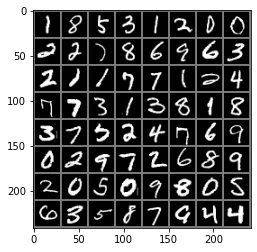

1 8 5 3 1 2 0 0


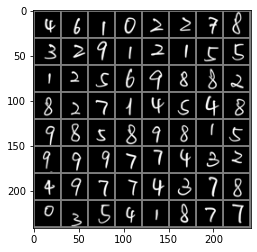

4 6 1 0 2 2 7 8


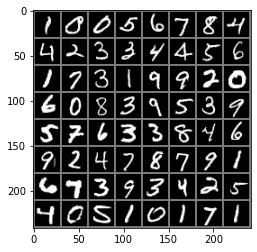

1 0 0 5 6 7 8 4


In [ ]:
def visualize_data(dataloader):
    def imshow(img):
        img = img / 2 + 0.5  # Unnormalize the image
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    # Get some random images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)  # Get a batch of training data

    # Show images
    imshow(torchvision.utils.make_grid(images))

    # Print the first 8 labels
    print(' '.join(f'{labels[j]}' for j in range(8)))
    

visualize_data(mnist_train_loader)
visualize_data(custom_loader)
visualize_data(combined_train_loader)

## Define the BP net

### Model

In [ ]:
class BP_Net(nn.Module):
    def __init__(self):
        super(BP_Net, self).__init__()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(28*28, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x


mnist_model = BP_Net()
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=learning_rate)

combined_model = BP_Net()
combined_criterion = nn.CrossEntropyLoss()
combined_optimizer = torch.optim.Adam(combined_model.parameters(), lr=learning_rate)

### Train

In [ ]:
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    print(f'Learning rate: {learning_rate}')
    print(f'Batch size: {batch_size}')
    print(f'Epochs: {num_epochs}')
    print()
    
    train_loss = []

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    plt.plot(train_loss, label='train loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training curve')
    plt.legend()
    plt.show()


print(f'Train on MNIST dataset')
train_model(mnist_model, mnist_criterion, mnist_optimizer, mnist_train_loader, num_epochs)

print('\n\n')

print(f'Train on combined dataset')
train_model(combined_model, combined_criterion, combined_optimizer, combined_train_loader, num_epochs)

Train on MNIST dataset
Learning rate: 0.001
Batch size: 64
Epochs: 10

Epoch [1/10], Step [100/938], Loss: 0.6045
Epoch [1/10], Step [200/938], Loss: 0.5932
Epoch [1/10], Step [300/938], Loss: 0.4814
Epoch [1/10], Step [400/938], Loss: 0.5762
Epoch [1/10], Step [500/938], Loss: 0.3759
Epoch [1/10], Step [600/938], Loss: 0.3213
Epoch [1/10], Step [700/938], Loss: 0.3190
Epoch [1/10], Step [800/938], Loss: 0.4809
Epoch [1/10], Step [900/938], Loss: 0.4189
Epoch [2/10], Step [100/938], Loss: 0.2795
Epoch [2/10], Step [200/938], Loss: 0.5727
Epoch [2/10], Step [300/938], Loss: 0.3421
Epoch [2/10], Step [400/938], Loss: 0.2449
Epoch [2/10], Step [500/938], Loss: 0.2991
Epoch [2/10], Step [600/938], Loss: 0.2378
Epoch [2/10], Step [700/938], Loss: 0.2532
Epoch [2/10], Step [800/938], Loss: 0.2315
Epoch [2/10], Step [900/938], Loss: 0.2830
Epoch [3/10], Step [100/938], Loss: 0.0830
Epoch [3/10], Step [200/938], Loss: 0.1206
Epoch [3/10], Step [300/938], Loss: 0.2403
Epoch [3/10], Step [400/93

## Print confusion matrix

Evaluate MNIST model
Accuracy of the network on the test images: 96.139%


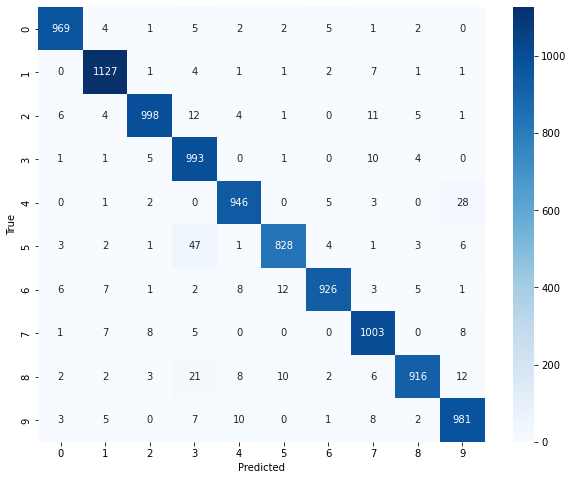

Evaluate combined model
Accuracy of the network on the test images: 96.715%


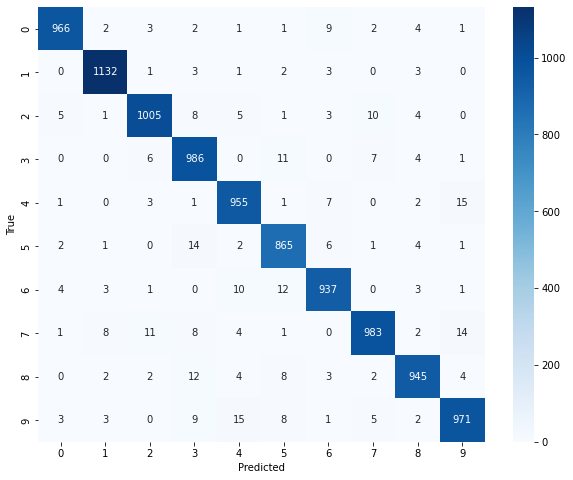

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
            total += labels.size(0)  # Increment the total count
            correct += (predicted == labels).sum()  # Increment the correct count
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
        print(f'Accuracy of the network on the test images: {100 * correct / total:.3f}%')
        
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        

print(f'Evaluate MNIST model')
evaluate_model(mnist_model, combined_test_loader)
print(f'Evaluate combined model')
evaluate_model(combined_model, combined_test_loader)